In [2]:
# TensorFlow and tf.keras
# import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import layers
import pandas as pd

import keras
from keras import layers
import keras.backend
from keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout
import keras.models
import keras.utils

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize
import math
import time
import h5py
import sklearn
import os

Using TensorFlow backend.


In [4]:
grid = 32
# training data : 10,000 signal samples and 10,000 bkg samples
traindata_sig = np.load('data/jetImages_signal.npz')
traindata_bkg = np.load('data/jetImages_bkg.npz')
trainimages = np.concatenate((traindata_sig['jetImages'], traindata_bkg['jetImages']),axis=0)
trainlabels = np.concatenate((traindata_sig['labels'],traindata_bkg['labels']),axis=0)
# testing data : 10,000 signal samples and 10,000 bkg samples
testdata_sig = np.load('data/jetImages_signal_test.npz')
testdata_bkg = np.load('data/jetImages_bkg_test.npz')
testimages = np.concatenate((testdata_sig['jetImages'], testdata_bkg['jetImages']),axis=0)
testlabels = np.concatenate((testdata_sig['labels'], testdata_bkg['labels']),axis=0)

n_test = len(testlabels)
n_train = len(trainlabels)
trainimages = trainimages.reshape(n_train, grid, grid, 1)
testimages = testimages.reshape(n_test, grid, grid, 1)

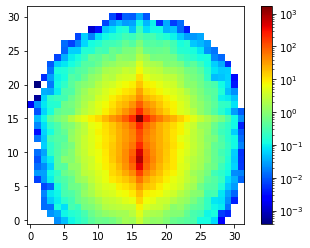

In [5]:
#plot input signal and background
sig_trainimages = np.zeros_like(trainimages[1])
bkg_trainimages = np.zeros_like(trainimages[1])
for i in range(len(trainimages)):
    if testlabels[i] == 1:
        sig_trainimages += trainimages[i]
    else:
        bkg_trainimages += trainimages[i]
#signal
display_sig = sig_trainimages.reshape(grid,grid)
plt.grid(False)
plt.imshow(display_sig, interpolation='nearest', origin='low', cmap = 'jet', norm=LogNorm())
plt.colorbar()
plt.show()

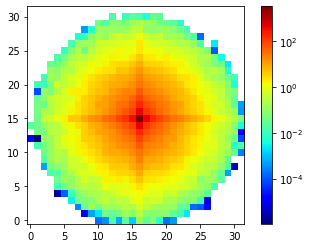

In [6]:
#background
display_bkg = bkg_trainimages.reshape(grid,grid)
plt.grid(False)
plt.imshow(display_bkg, interpolation='nearest', origin='low', cmap = 'jet', norm=LogNorm())
plt.colorbar()
plt.show()

In [ ]:
# !ls training
best_model = keras.models.load_model('model/CNN_sparce_cat.h5')
best_model.summary()
results = best_model.evaluate(testimages, testlabels)
print(results)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 22, 22, 32)        3904      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 32)          9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 32)          9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 32)          0         
______________________

In [ ]:
# Plot ROC
predict = best_model.predict(testimages)
print(testlabels.shape, predict.shape)
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(testlabels, predict)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='blue', label='auc = %.3f' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('receiver operating curve')
plt.legend(loc="lower right")
plt.show()

In [7]:
import innvestigate
import innvestigate.utils as iutils

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


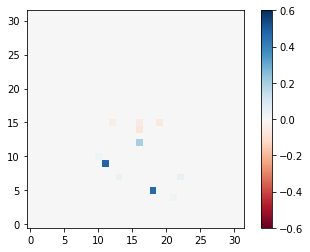

In [8]:
# Creating an analyzer
lrp_analyzer = innvestigate.create_analyzer("lrp.z", best_model)

# Applying the analyzer
display = trainimages[1].reshape(1,grid,grid,1) #the reshape is this way is because the input is expected to be 4 dimensions
analysis = lrp_analyzer.analyze(display)

# Displaying one result
plt.imshow(analysis.reshape(grid, grid), cmap='RdBu', origin = 'low', interpolation='nearest')
plt.colorbar()
plt.clim(-0.6, 0.6)
plt.show()

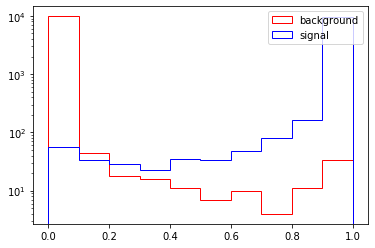

In [9]:
plt.hist([predict[:int(len(predict)/2)].flatten(), predict[int(len(predict)/2):-1].flatten()] ,
         color = ['blue', 'red'], histtype = 'step', label = ['signal', 'background'])
plt.yscale('log')
plt.legend()
plt.show()

In [10]:
#plot output signal and background
sig_analysis_true = np.zeros_like(analysis)
bkg_analysis_true = np.zeros_like(analysis)
sig_analysis_pred = np.zeros_like(analysis)
bkg_analysis_pred = np.zeros_like(analysis)
sig_inefficiency = np.zeros_like(analysis)
bkg_inefficiency = np.zeros_like(analysis)

toc = time.time()

display = trainimages.reshape(len(trainimages), 1, grid, grid, 1) 
analysis = [lrp_analyzer.analyze(display[i]) for i in range(len(trainimages))]

tic = time.time()

print('\n time = \n', tic-toc)



 time = 
 63.48545026779175


In [17]:
toc = time.time()

for i in range(len(trainimages)):
    if trainlabels[i] == 1:
        sig_analysis_true += analysis[i]  
        
    else:
        bkg_analysis_true += analysis[i]

sig_analysis_true /= len(trainimages)/2
bkg_analysis_true /= len(trainimages)/2
        
sig_anal_num = 0   
sig_inef_num = 0
bkg_anal_num = 0
bkg_inef_num = 0
weird = 0

for i in range(len(trainimages)):
    if i < int(len(predict)/2) and predict[i] > 0.50:
        sig_analysis_pred += analysis[i]
        sig_anal_num += 1
    elif i < int(len(predict)/2) and predict[i] < 0.50:
        sig_inefficiency += analysis[i]
        sig_inef_num += 1
    elif i >= int(len(predict)/2) and predict[i] < 0.50:
        bkg_analysis_pred += analysis[i]
        bkg_anal_num += 1
    elif i >= int(len(predict)/2) and predict[i] > 0.50:
        bkg_inefficiency += analysis[i]
        bkg_inef_num += 1
        
#normalizing relevance scores
sig_analysis_pred /= sig_anal_num
sig_inefficiency /= sig_inef_num
bkg_analysis_pred /= bkg_anal_num
bkg_inefficiency /= bkg_inef_num

tic = time.time()
print('signal inefficiency = ', sig_inef_num, '\nbackground inefficiency = ', bkg_inef_num)
print('\ntime =\n', tic-toc)


signal inefficiency =  176 
background inefficiency =  65

time =
 0.18496131896972656


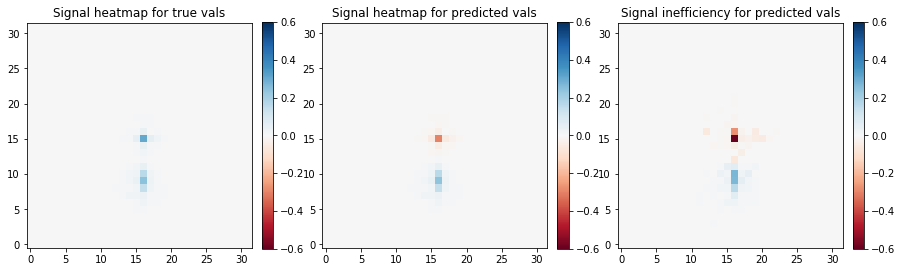

In [12]:
# Displaying the signal results
ax = plt.figure(figsize = (15,15))
ax.add_subplot(131)
im = plt.imshow(np.absolute(sig_analysis_true.reshape(grid,grid)), origin = 'low',cmap='RdBu', interpolation='nearest')
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.clim(-0.6, 0.6)
plt.title('Signal heatmap for true vals')
ax.add_subplot(132)
im = plt.imshow(sig_analysis_pred.reshape(grid,grid), origin = 'low', cmap='RdBu', interpolation='nearest')
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.clim(-0.6, 0.6)
plt.title('Signal heatmap for predicted vals')
ax.add_subplot(133)
im = plt.imshow(sig_inefficiency.reshape(grid,grid), origin = 'low', cmap='RdBu', interpolation='nearest')
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.clim(-0.6, 0.6)
plt.title('Signal inefficiency for predicted vals')
plt.show()


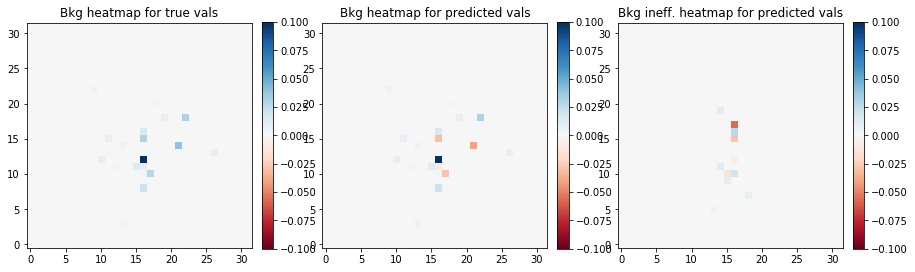

In [13]:
# Displaying the background results
ax = plt.figure(figsize = (15,15))
ax.add_subplot(131)
im_ = plt.imshow(np.absolute(bkg_analysis_true.reshape(grid,grid)), origin = 'low',cmap='RdBu', interpolation='nearest')
plt.colorbar(im_,fraction=0.046, pad=0.04)
plt.clim(-0.10, 0.10)
plt.title('Bkg heatmap for true vals')
ax.add_subplot(132)
im_ = plt.imshow(bkg_analysis_pred.reshape(grid,grid), origin = 'low',cmap='RdBu', interpolation='nearest')
plt.colorbar(im_,fraction=0.046, pad=0.04)
plt.clim(-0.10, 0.10)
plt.title('Bkg heatmap for predicted vals')
ax.add_subplot(133)
im = plt.imshow(bkg_inefficiency.reshape(grid,grid), origin = 'low', cmap='RdBu', interpolation='nearest')
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.clim(-0.10, 0.10)
plt.title('Bkg ineff. heatmap for predicted vals')
plt.show()